In [2]:
from collections import Counter
import pandas as pd
import rpy2.rinterface
import numpy as np
import glob
import os
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## TGCA Survival Analysis of Pancreatic Cancer Patients

### Modified from similar workflow described on biostars.org: https://www.biostars.org/p/153013/

In [3]:
# Download raw counts from Xena, place tsv in data folder
# https://gdc.xenahubs.net/download/TCGA-PAAD/Xena_Matrices/TCGA-PAAD.htseq_counts.tsv.gz

In [4]:
HTSeq_raw_df = pd.read_csv("data/rna/raw_counts/TCGA-PAAD.htseq_counts.tsv", sep="\t")

In [5]:
# These counts are actually partially processed from raw HTSeq counts (they have been incremented by one then log transformed)
# Reversing this process will give the actual raw counts

HTSeq_raw_counts_df = pd.DataFrame()
HTSeq_raw_counts_df['Ensembl_ID'] = HTSeq_raw_df['Ensembl_ID']
for column in HTSeq_raw_df.columns.values[1:]:
    series = HTSeq_raw_df[column]
    series_antilog = (2**series) - 1
    HTSeq_raw_counts_df[column] = series_antilog
       

In [6]:
# Builds a dictionary of what samples correspond to normal tissue and what samples correspond to tumor tissue
# More can be read about how sample barcoding works in the TCGA here: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/

origin_dict = {}
for column in list(HTSeq_raw_counts_df)[1:]:
    if column[13] == '0':
        origin_dict[column] = 'tumor'
    elif column[13] == '1':
        origin_dict[column] = 'normal'

In [7]:
# There should be 178 samples corresponding to tumors and 4 samples corresponding to normal tissue

Counter(origin_dict.values())

Counter({'tumor': 178, 'normal': 4})

In [8]:
# For this analysis, only tumor samples are used
# HTSeq_raw_counts_df is subset to just get tumor samples
# Normal samples are not used in this analysis

slice_list = ['Ensembl_ID']
for column, value in origin_dict.items():
    if value == 'tumor':
        slice_list.append(column)
        
HTSeq_raw_counts_tumors_df = HTSeq_raw_counts_df[slice_list]

In [9]:
# Lowly expressed genes (genes that have counts of 0 in 50% of samples) are removed

zeroes = (HTSeq_raw_counts_tumors_df == 0).astype(int)
zeroes_count = zeroes.sum(axis=1).to_frame()
length = zeroes.shape[1]
zeroes_count = zeroes_count.drop(zeroes_count[zeroes_count[0] < length/2].index)
drop_index_list = zeroes_count.index.to_list()
HTSeq_raw_counts_tumors_no_zeroes_df = HTSeq_raw_counts_tumors_df.drop(labels=drop_index_list)

In [10]:
# Counts are floats currently, but need to be convereted to integers of DESeq2 will complain

for column in HTSeq_raw_counts_tumors_no_zeroes_df.columns.values[1:]:
    HTSeq_raw_counts_tumors_no_zeroes_df[column] = HTSeq_raw_counts_tumors_no_zeroes_df[column].astype(int)
    

In [11]:
# Any files that are currently in the tumor_samples folder should be deleted

tumor_sample_dir = 'data/rna/tumor_samples/'
files = glob.glob(tumor_sample_dir + '*')
for f in files:
    os.remove(f)
    
# A tsv corresponing to the raw counts for each tumor is saved in the tumor_samples folder
# This is needed to pass off the data to R

for column in HTSeq_raw_counts_tumors_no_zeroes_df.columns.values[1:]:
    file_name = 'data/rna/tumor_samples/' + column + '.tsv'
    HTSeq_raw_counts_tumors_no_zeroes_df[['Ensembl_ID', column]].to_csv(file_name, sep=" ", header=False, index=False)

In [12]:
%%R

# DESeq2 is loaded

library("DESeq2")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, 

In [14]:
%%R

# Builds a sampleTable based on the data files in the tumor_samples directory

rna_data_directory <- 'data/rna/tumor_samples'

sampleFiles <- list.files(rna_data_directory)
sampleNames <- gsub(".tsv", "", sampleFiles)
sampleCondition <- c(rep("tumor", length(sampleNames)))
sampleTable <- data.frame(sampleName = sampleNames,
                          fileName = sampleFiles,
                          condition = sampleCondition)

In [15]:
%%R

# A DESeq dataset is constructed using the sampleTable and the path to the tumor_samples directory
# The design is set to 1 to indicate that there are no factors dividing these groups (this could be changed if desired)

dds <- DESeqDataSetFromHTSeqCount(sampleTable = sampleTable,
                                       directory = rna_data_directory,
                                       design= ~ 1)

In [16]:
%%R

# The DESeq dataset is transformed using the log-like variance stabilizing transformation

transformed_dds <- vst(dds, blind=TRUE)
    


In [17]:
%%R

# The transformed_dds_matrix object is a summarized experiement object
# This is just a matrix of the transformed counts
# This matrix is then saved to the temp folder for passing off to Python

transformed_dds_matrix <- assay(transformed_dds)
write.csv(transformed_dds_matrix, "data/temp/transformed_dds_matrix.csv")


In [44]:
# The transformed_dds is loaded into the Python environment with Pandas

transformed_dds_matrix = pd.read_csv("data/temp/transformed_dds_matrix.csv")
transformed_dds_matrix = transformed_dds_matrix.rename(index=str, columns={"Unnamed: 0": "Ensembl_ID"})

In [45]:
# calculate the high and low expression cutoff for each row 

sample_columns = transformed_dds_matrix.columns.values[1:]
high_expression_cutoff = transformed_dds_matrix[sample_columns].apply(lambda x: np.percentile(x, 50), axis=1)
low_expression_cutoff = transformed_dds_matrix[sample_columns].apply(lambda x: np.percentile(x, 50), axis=1)

transformed_dds_matrix['high_expression_cutoff'] = high_expression_cutoff
transformed_dds_matrix['low_expression_cutoff'] = low_expression_cutoff

In [46]:
# Download "merge_clinical" clinical data from http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PAAD/20160128/gdac.broadinstitute.org_PAAD.Merge_Clinical.Level_1.2016012800.0.0.tar.gz
# Extract and place the "GBM.merged_only_clinical_clin_format.txt" file in the "data/clinical" folder
# Read the Clinical file, in this case I transposed it to keep the clinical feature title as column name

clinical_dir = 'data/clinical/PAAD.merged_only_clinical_clin_format.txt'
clinical_df = pd.read_csv(clinical_dir, sep='\t', index_col='V1').T


In [48]:
# Convert patient barcodes to uppercase

clinical_df['patient.bcr_patient_barcode'] = clinical_df['patient.bcr_patient_barcode'].str.upper()

In [49]:
# Get the most recent recording of days to death
# This should be unambiguous, but we take the max anyway just to pick one value if there are multiple entries

death_df = pd.DataFrame()
death_df['patient.bcr_patient_barcode']  = clinical_df['patient.bcr_patient_barcode']
for column in clinical_df:
    if 'days_to_death' in column:
        death_df[column] = clinical_df[column]
        death_df[column] = death_df[column].astype(float)
        death_df['death_days'] = death_df.max(axis=1)

death_df = death_df[['patient.bcr_patient_barcode', 'death_days']]

In [50]:
# Similarly get the most recent number for "days to last followup"
# Days_to_last_followup is the time interval from the date of last followup to the date of initial pathologic diagnosis
# This means the most recent followup would be the largest number

followup_df = pd.DataFrame()
followup_df['patient.bcr_patient_barcode']  = clinical_df['patient.bcr_patient_barcode']
for column in clinical_df:
    if 'days_to_last_followup' in column:
        followup_df[column] = clinical_df[column]
        followup_df[column] = followup_df[column].astype(float)
        followup_df['followup_days'] = followup_df.max(axis=1)

followup_df = followup_df[['patient.bcr_patient_barcode', 'followup_days']]

In [51]:
# Merge new_tumor_df, death_df, followup_df

df_list = [death_df, followup_df]
all_clinical_df = pd.DataFrame()
all_clinical_df['patient.bcr_patient_barcode'] = clinical_df['patient.bcr_patient_barcode']
for df in df_list:
    all_clinical_df = all_clinical_df.merge(df, on='patient.bcr_patient_barcode')

In [52]:
# Need to create a column for death that takes into account samples that need to be censored (patients that did not die)
# If the patient did die, the time to death will be recorded in this column
# If the patient did not die, the number of days since last followup will be recorded in this column

all_clinical_df['new_death']= np.where(all_clinical_df['death_days'].isnull(),all_clinical_df['followup_days'] , all_clinical_df['death_days'])

In [53]:
# Translate the alive and dead strings in the patient.vital_status column to 1 for dead and 0 for alive

alive_dead_df = clinical_df[['patient.bcr_patient_barcode', 'patient.vital_status']]
alive_dead_df['death_event'] = np.where(alive_dead_df['patient.vital_status'] == 'dead', 1, 0)
alive_dead_df = alive_dead_df[['patient.bcr_patient_barcode', 'death_event']]

/home/brett/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [54]:
# Merge the alive/dead data with the all_clincal_df data

all_clinical_df = all_clinical_df.merge(alive_dead_df, on='patient.bcr_patient_barcode')

In [55]:
# Function can be used to find a gene from an ensembl root
def find_gene_id(id):
    for item in transformed_dds_matrix['Ensembl_ID']:
        if id in item:
            return item
            
# The root ensembl id for MET is ENSG00000105976
print(find_gene_id('ENSG00000105976'))

# The root ensembl id for RON is ENSG00000105976
print(find_gene_id('ENSG00000164078'))

# The root ensembl id for HGF is ENSG00000019991
print(find_gene_id('ENSG00000019991'))

# The root ensembl id for MSP is ENSG00000173531
print(find_gene_id('ENSG00000173531'))

ENSG00000105976.13
ENSG00000164078.11
ENSG00000019991.14
ENSG00000173531.14


In [56]:
# Select row from transformed_dds_matrix with our gene of interest

gene_id = find_gene_id('ENSG00000164078.11')
gene_subset = transformed_dds_matrix[transformed_dds_matrix['Ensembl_ID'] == gene_id]

gene = 'ron'

In [57]:
# Transpose this selected data

gene_subset_transposed = gene_subset.T.reset_index()

# Prepare the header for merging with the clinical data 
new_header = ['patient.bcr_patient_barcode', 'normalized_counts']
gene_subset_transposed = gene_subset_transposed[1:]
gene_subset_transposed.columns = new_header

# Truncate barcodes for merging with the clinical data

gene_subset_transposed['patient.bcr_patient_barcode'].iloc[:-2] = gene_subset_transposed['patient.bcr_patient_barcode'].str[:-4]


In [58]:
# Get the high and low cutoff transformed count value from the dataframe for our gene

high_expression_cutoff = gene_subset_transposed.iloc[-2, 1]
low_expression_cutoff = gene_subset_transposed.iloc[-1, 1]

# Drop the cutoff rows from each of the dataframes

gene_subset_transposed = gene_subset_transposed.iloc[:-2]


In [59]:
# Merge the transformed count data from the gene of interest with the clinical data

all_clinical_df = all_clinical_df.merge(gene_subset_transposed, on='patient.bcr_patient_barcode')

In [60]:
# Generate a new series for the event_rna levels
all_clinical_df['event_rna'] = pd.Series()

# Code the samples as expressing the gene of interest above ('high_met') or below (low_met) the median expression level

all_clinical_df['event_rna'] = np.where(all_clinical_df['normalized_counts'] > high_expression_cutoff,'high_{}'.format(gene),all_clinical_df['event_rna'])
all_clinical_df['event_rna'] = np.where(all_clinical_df['normalized_counts'] < low_expression_cutoff, 'low_{}'.format(gene), all_clinical_df['event_rna'])
all_clinical_df['event_rna'] = all_clinical_df['event_rna'].replace('nan', 'medium_{}'.format(gene))
all_clinical_df = all_clinical_df[all_clinical_df['event_rna'] != 'medium_{}'.format(gene)]


In [61]:
# Save the all_clincal_df to the temp folder

all_clinical_df.to_csv("data/temp/all_clinical_df.csv", index=False)

In [62]:
%%R

# Load the survival library and survminer for plotting
library(survival)
library(survminer)

In [63]:
%%R

# Some good links for survival analysis: https://www.datacamp.com/community/tutorials/survival-analysis-R,
# http://www.sthda.com/english/wiki/survival-analysis-basics

# Read in the all_clinical_df from the temp folder

all_clinical_df <- read.csv(file="data/temp/all_clinical_df.csv", header=TRUE, sep=",")

# Relevel the factors to have low expression as the reference factor

set_factor_levels <- function(all_clinical_df, gene) {
    
    all_clinical_df$event_rna <- factor(all_clinical_df$event_rna, levels = c(paste("low", gene, sep="_"),
                                                                              paste("medium", gene, sep="_"),
                                                                         paste("high", gene, sep="_")))
    return(all_clinical_df)
}

all_clinical_df <- set_factor_levels(all_clinical_df, 'ron')

# Create the survival object with the time to death/last followup and death event data 
survival_object <- Surv(time=all_clinical_df$new_death, event=all_clinical_df$death_event)

# Fit the Kaplan-Meier curve with the survfit function

fit <- survfit(formula = survival_object ~ event_rna, data = all_clinical_df)
fit


Call: survfit(formula = survival_object ~ event_rna, data = all_clinical_df)

                    n events median 0.95LCL 0.95UCL
event_rna=low_ron  89     24   1502     738      NA
event_rna=high_ron 89     34   1059     634      NA


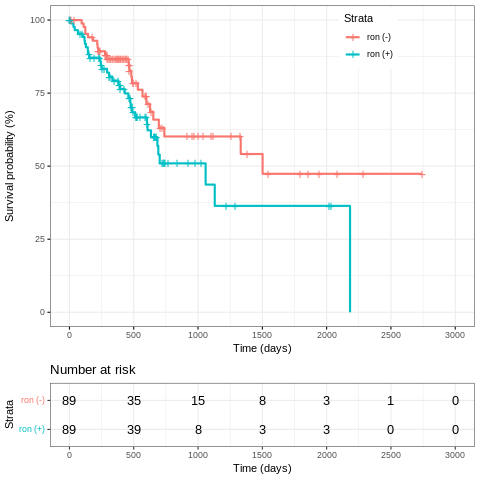

In [64]:
%%R

# Plot the Kaplan-Meier curve
# P value on plot is the result of log-rank test
# Talks about survival probability: https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
# https://altis.com.au/a-crash-course-in-survival-analysis-customer-churn-part-i/
ggsurvplot(fit, data = all_clinical_df, pval = FALSE, legend = c(.75,.9), fun='pct', break.time.by=500, 
           risk.table = TRUE,
          xlab = "Time (days)",
          ggtheme = theme_bw(),
          legend.labs = 
    c("ron (-)", "ron (+)"))

In [65]:
%%R

# Cox reggression
# http://www.sthda.com/english/wiki/cox-proportional-hazards-model
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5514049/
# http://clincancerres.aacrjournals.org/content/11/6/2222.full-text.pdf
# 

# Hazard ratio of https://www.students4bestevidence.net/tutorial-hazard-ratios/

res.cox <- coxph(Surv(new_death, death_event) ~ event_rna, data=all_clinical_df)
res.cox.extended <- summary(res.cox)
capture.output(res.cox.extended, file = "data/rna/univariate/ron.txt")